In [1]:
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import re
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import networkx.algorithms.community as comms


In [2]:
DATA = '../Data/out.moreno_crime_crime'
ROLE = '../Data/rel.moreno_crime_crime.person.role'
NAME = '../Data/ent.moreno_crime_crime.person.name'
SEX =  '../Data/ent.moreno_crime_crime.person.sex'

In [3]:
with open(DATA) as f:
    data = f.read().splitlines()
    
with open(ROLE) as f:
    role = f.read().splitlines()
    
with open(NAME) as f:
    name = f.read().splitlines()
    
with open(SEX) as f:
    sex = f.read().splitlines()
    
for i in range(len(data)):
    data[i] = 'p' + data[i] # adds 'p' to the People nodes to differentiate them

In [4]:
lasts = []
firsts = []
for n in name:
    lasts.append((re.findall('[A-Z][^A-Z]*', n))[0])
    firsts.append((re.findall('[A-Z][^A-Z]*', n))[1])

In [110]:
#Read in graph and find and isolate the greatest connected component

B = nx.read_edgelist(data)
graph = np.loadtxt(DATA, dtype=str)
a = np.unique(graph[:,0]) # people nodes
b = np.unique(graph[:,1]) # crime nodes
a = ['p' + a for a in a] # add string to differentiate

G = nx.Graph()

# add nodes
for j in range(len(a)):
    G.add_node(a[j], bipartite=0, data=True, first=firsts[j], last=lasts[j], sex=sex[j], Community = []) #Add attributes name and sex

G.add_nodes_from(b, bipartite=1, data=True)

# add edges
i = 0
for edge in B.edges():
    G.add_edge(edge[0], edge[1], role=role[i])
    i+=1

p_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0} # people
c_nodes = set(G) - p_nodes # crimes

# components in the graph sorted in descendent order
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
# selecting the biggest component
G0 = G.subgraph(Gcc[0])

P 754 2127


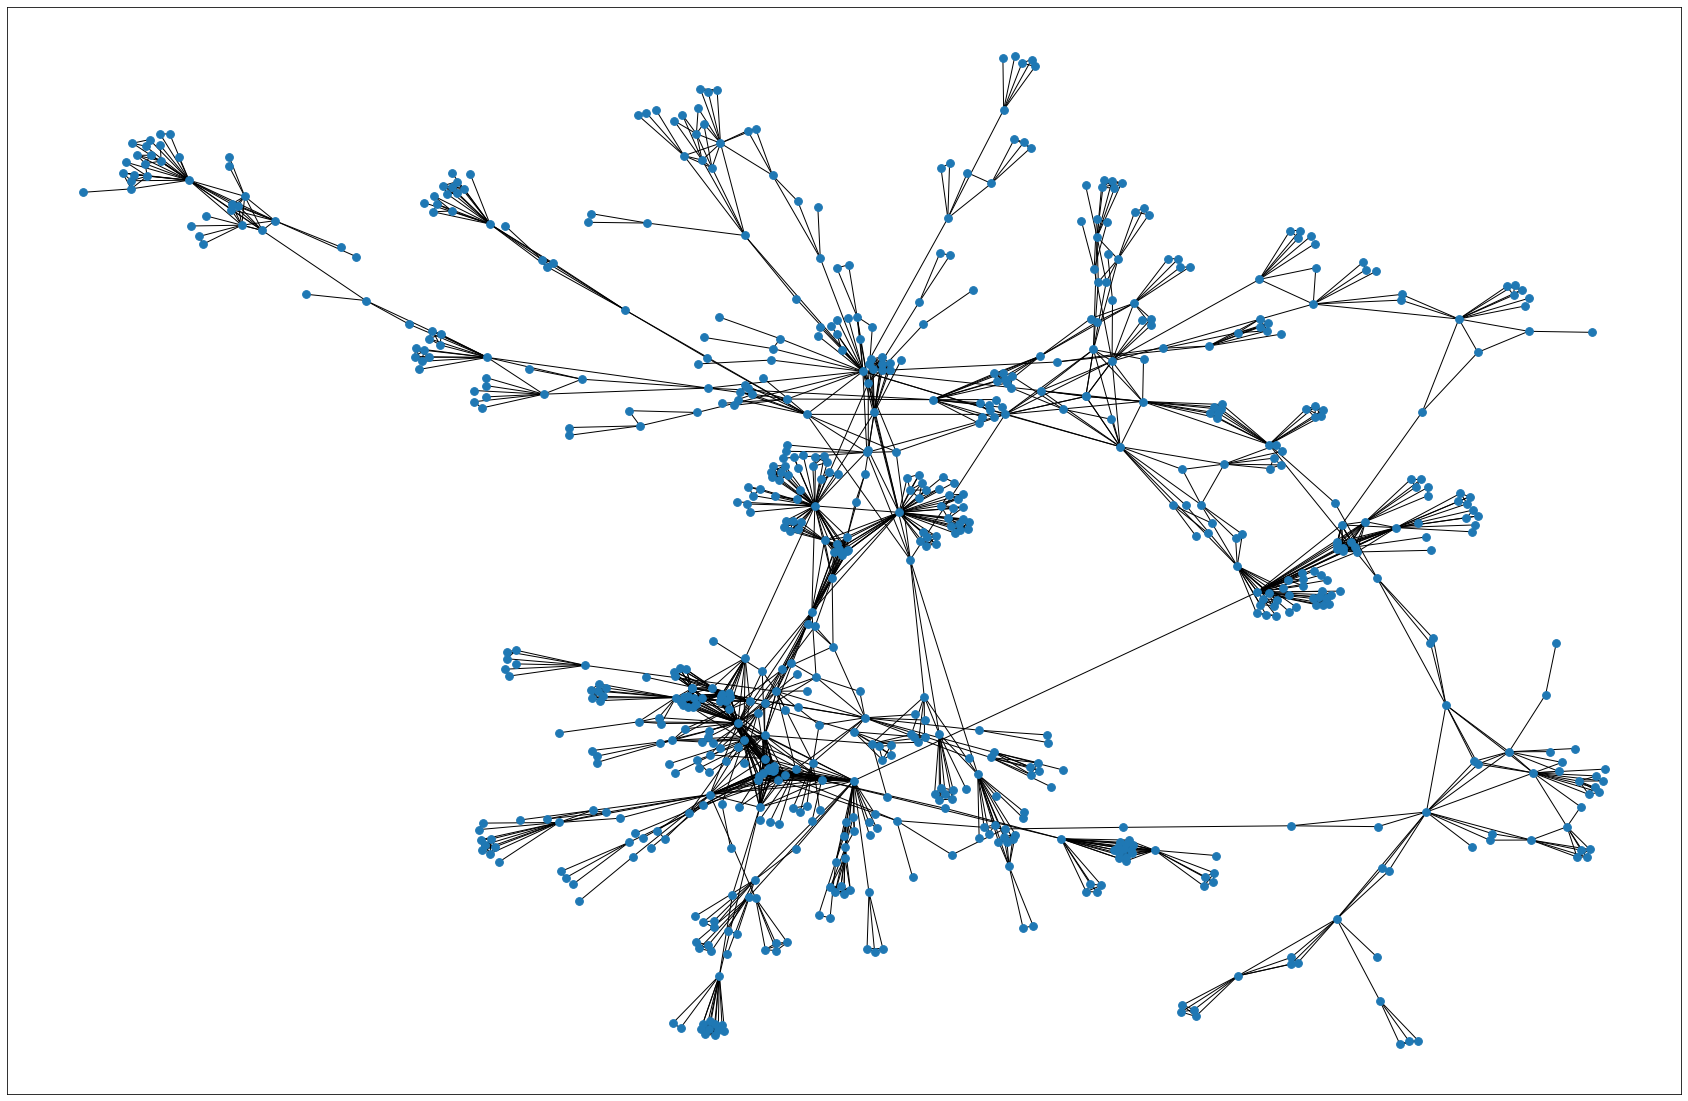

In [38]:
#Seperate the nodes for People and Crimes
p_nodes_gcc = {n for n, d in G0.nodes(data=True) if d["bipartite"] == 0}
c_nodes_gcc = set(G0) - p_nodes_gcc

#print(len(p_nodes_gcc), len(c_nodes_gcc))

# project onto people and visualise
P = bipartite.weighted_projected_graph(G0, p_nodes_gcc)

print('P',len(P.nodes()), len(P.edges()))

plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(P, seed=23)

nx.draw_networkx(P, pos, node_size=60, with_labels=False)

In [39]:
# Initialize a dictionary based on people nodes to keep track of all roles per node
p_nodes = {el:[] for el in p_nodes_gcc}

# Add all the edge attributes to a dictionary of people nodes
for key,value in nx.get_edge_attributes(G, 'role').items():
    for part in key:
        if part in p_nodes_gcc:
            p_nodes[part].append(value)
#print(p_nodes)

# Initialize a dictionary to keep track of who is a "criminal"
criminals = {el:[] for el in p_nodes_gcc}

# Loop through all roles per node, and deem them criminals if ever they have been a suspect
for key in p_nodes:
    for value in p_nodes[key]:
        if value == "Suspect":
            criminals[key] = "Criminal"
            break
        elif value == "Victim Suspect":
            criminals[key] = "Criminal"
            break
        else:
            criminals[key] = "Innocent"

# Convert to pandas df
criminals_df = pd.DataFrame(criminals.items(), columns=['node', 'Criminal_Status'])

# loop through rows in the data frame and add the attribute of Criminal Status
for index, row in criminals_df.iterrows():
    #print(row['node'])
    G.nodes[row['node']]['Criminal_Status'] = row['Criminal_Status']
    
#criminals_df

In [40]:
bet_centrality = nx.betweenness_centrality(P, normalized = True, 
                                              endpoints = False)

In [9]:
bet_cent_list = sorted(bet_centrality.values(), reverse=True)

max(bet_centrality.values())

0.4228002367562995

In [10]:
for k,v in bet_centrality.items():
    if v == bet_cent_list[0]:
        print(f"POI is set to '{k}'")
        POI = k

POI is set to 'p815'


In [11]:
POI = 'p668' #set a Person of Interest if not using the highest betweeness centrality person

In [12]:
class Dunno:
    
    def __init__ (self, G, POI='p1', highlight=0, Gcc=True):
        
        if Gcc:
            comp_list = sorted(nx.connected_components(G), key=len, reverse=True)
            self.G = G.subgraph(comp_list[0])
            print(f'Using the largest connected component of the graph, with {len(self.G.nodes())} nodes')
        else:
            self.G = G
        self.POI = POI
        self.highlight = highlight
        self.communities = sorted(comms.greedy_modularity_communities(self.G, weight='weight'), key=len, reverse=True)
        self.modularity = comms.modularity(self.G, self.communities)
        self.p_nodes = []
        self.c_nodes = []
        for node in self.G.nodes:
            if 'p' in node:
                self.p_nodes.append(node)
            else:
                self.c_nodes.append(node)
                
        if len(self.c_nodes) == 0:
            self.proj = self.G
            self.isproj=True
            print('This graph only has people in it, no crimes')
        else:
            self.proj = bipartite.weighted_projected_graph(self.G, self.p_nodes)
            self.isproj=False
        
    def com_find(self, proj=False):
        if proj:
            self.communities = sorted(comms.greedy_modularity_communities(self.proj, weight='weight'), key=len, reverse=True)
            self.modularity = comms.modularity(self.proj, self.communities)
            
        print(f"There are {len(self.communities)} communities.")
        found = False
        for i in range(len(self.communities)):
            if self.POI in self.communities[i]:
                print(f'The POI is in community {i}')
                found = True
                self.highlight = i #sets the POI's community to be highlighted in graphs below
        if not found:
            print(f'POI not found in this component, highlight defaults to {highlight}')
    
    def com_plot(self, save=False, plot_st = 0, plot_end=100, fig=(20,15), col='blue'):
        a = min(plot_end, len(self.communities))
        b = a//5
        if b == 0:
            b=1
        
        fig, ax = plt.subplots(figsize=fig)
        fig.tight_layout()
        
        
        for i in range(plot_st,a): 
            com = self.proj.subgraph(self.communities[i])
            print(i, len(com.nodes), len(com.edges))

            plt.subplot(b,5,i+1)
            nx.draw_spring(com, node_size=40, node_color=col)
        if save:
            plt.savefig(f'../Figures/communities.jpg')
        
    def high_com(self, proj=False, hi_col = 'red', oth_col='blue', crime_col = 'green', save=False):
        node_col = []
        if proj:
            G = self.proj
        else:
            G = self.G
            
        for node in G.nodes():
            if node in self.c_nodes:
                node_col.append(crime_col)
            elif node in self.communities[self.highlight]:
                node_col.append(hi_col)
            else:
                node_col.append(oth_col)

        
        plt.rcParams.update({'figure.figsize': (30, 20)})
        pos = nx.spring_layout(G, seed=23)

        nx.draw_networkx(G, pos,
                         node_size=80,
                         node_color=node_col,
                         with_labels=False)
        
        hi_patch = mpatches.Patch(color=hi_col, label=f'Community {self.highlight}')
        oth_patch = mpatches.Patch(color=oth_col, label=f'All other nodes')
        cri_patch = mpatches.Patch(color=crime_col, label=f'Crime nodes')
        if len(c_nodes) > 0 and not proj:
            hand = [hi_patch, oth_patch, cri_patch]
        else: 
            hand = [hi_patch, oth_patch]
        plt.legend(handles=hand, fontsize='xx-large')
         
        if save:
            plt.savefig(f'../Figures/community_{self.highlight}_highlight.jpg')
            
    def labled_comm(self, POI_col='aqua', male_col='blue', 
                    female_col='magenta', crime_col='green',
                   vic_col='blue', sus_col='red',
                    wit_col='green', other_col='black', save=False):
        ed = []
        lab = {}
        hand1 = []
        hand2 = []
        
        POI_patch = mpatches.Patch(color=POI_col, label=f'POI node')
        male_patch = mpatches.Patch(color=male_col, label=f'Male node')
        female_patch = mpatches.Patch(color=female_col, label=f'Female node')
        crime_patch = mpatches.Patch(color=crime_col, label=f'Crime node')
        
        vic_line = mlines.Line2D([], [], color=vic_col, label='Victim role')
        sus_line = mlines.Line2D([], [], color=sus_col, label='Suspect role')
        wit_line = mlines.Line2D([], [], color=wit_col, label='Witness role')
        other_line = mlines.Line2D([], [], color=other_col, label='Dual role')
        
        for per in self.communities[self.highlight]:
            if 'p' in per:
                lab[per] = (f"{nx.get_node_attributes(self.G, 'first')[per]} {nx.get_node_attributes(self.G, 'last')[per]} \n({per})")
                if self.isproj == False:
                    for c in self.G.edges([per]):
                        ed.append(c[1])
                        lab[c[1]] = f'{c[1]}'
            else:
                lab[per] = f'{per}'

        for i in self.communities[self.highlight]:
            ed.append(i)
  
        nc = []
        ec = []

        hi = self.G.subgraph(ed)

        for node in hi:
            if node in self.c_nodes:
                nc.append(crime_col)
                hand1.append(crime_patch)
            elif node in self.communities[self.highlight]:
                if node == POI:
                    nc.append(POI_col)
                    hand1.append(POI_patch)
                elif nx.get_node_attributes(self.G, 'sex')[node] == '1':
                    nc.append(male_col)
                    hand1.append(male_patch)
                else:
                    nc.append(female_col)
                    hand1.append(female_patch)
            else:
                nc.append('yellow') #none should ever show yellow!! something is wrong if they do
        
        if self.isproj==False:
            for edge in hi.edges():
                a = nx.get_edge_attributes(hi, 'role')[edge]
                if a == 'Victim':
                    ec.append(vic_col)
                    hand2.append(vic_line)
                elif a == 'Suspect':
                    ec.append(sus_col)
                    hand2.append(sus_line)
                elif a == 'Witness':
                    ec.append(wit_col)
                    hand2.append(wit_line)
                else:
                    ec.append(other_col)
                    hand2.append(other_line)
        else:
            ec = other_col

        hand = list(set(hand1)) + (list(set(hand2)))
        plt.rcParams.update({'figure.figsize': (25, 25)})
        pos = nx.spring_layout(hi, weight=None, k=0.2, seed=23)

        nx.draw_networkx(hi, pos, node_size=200, node_color=nc, edge_color=ec, labels=lab)
        plt.legend(handles=hand, fontsize='xx-large')
        if save:
            plt.savefig(f'../Figures/community_{self.highlight}_focus.jpg')



Using the largest connected component of the graph, with 1263 nodes
There are 31 communities.
The POI is in community 8


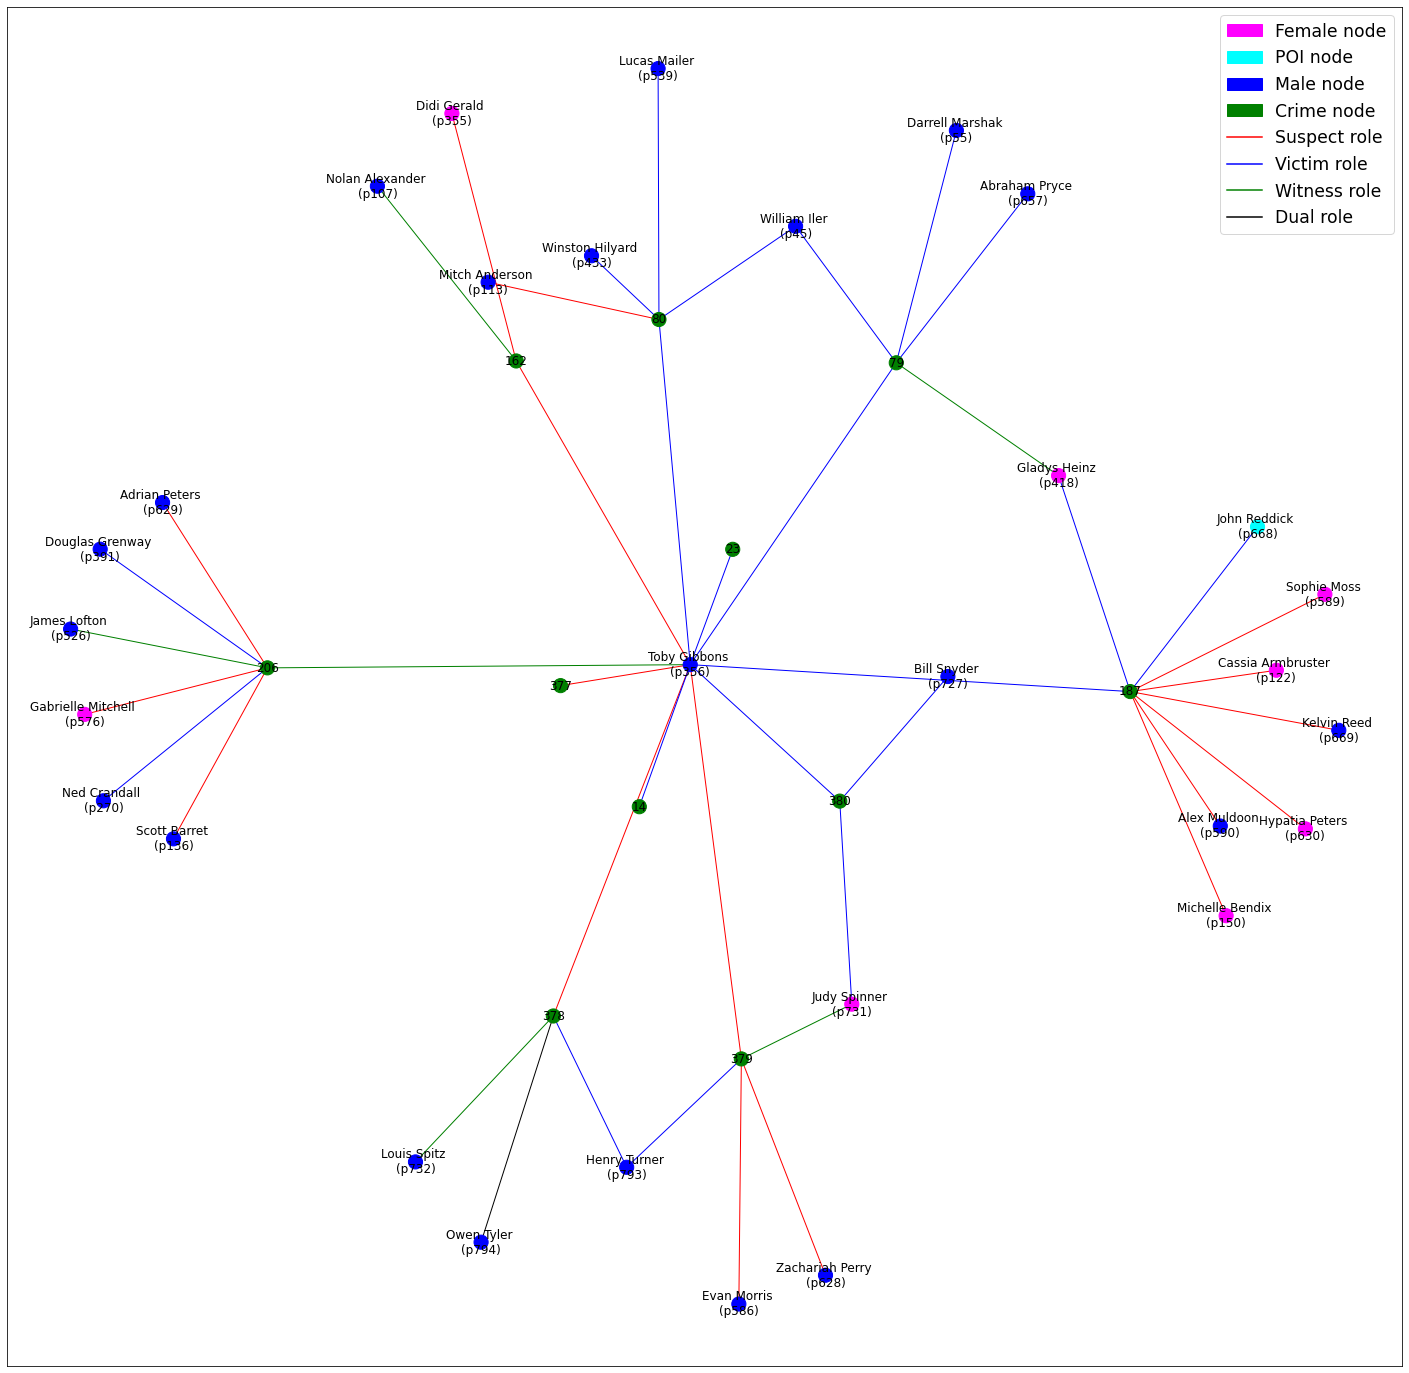

In [13]:
thing = Dunno(G, POI) #will default to using the largest connected component unless you state Gcc=False

thing.com_find(proj=True) #set proj=True if you want to find communities for the people projection, else it will use the entire graph you gave it. 
#Once projection is set to true, it overwrites the communities from the entire graph, so it will always be working on the projection.
#print(f'Modularity of network communities: {thing.modularity}')
#thing.com_plot(plot_end=10, col='blue') 

#thing.high_com(hi_col='magenta',oth_col='aqua',) #use proj=True to draw the projected graph, or defaults to drawing the whole graph
thing.labled_comm()

In [14]:
for edge in thing.proj.edges():
    if nx.get_edge_attributes(thing.proj, 'weight')[edge] > 1:
        print(edge, nx.get_edge_attributes(thing.proj, 'weight')[edge])


('p10', 'p568') 2
('p10', 'p225') 2
('p112', 'p511') 2
('p114', 'p497') 2
('p115', 'p633') 2
('p128', 'p531') 5
('p128', 'p533') 2
('p129', 'p155') 2
('p155', 'p174') 2
('p159', 'p284') 2
('p17', 'p514') 4
('p2', 'p338') 2
('p2', 'p361') 2
('p2', 'p67') 4
('p2', 'p33') 2
('p2', 'p356') 2
('p214', 'p216') 2
('p220', 'p729') 2
('p242', 'p398') 2
('p291', 'p812') 2
('p303', 'p56') 3
('p303', 'p57') 2
('p326', 'p37') 2
('p333', 'p592') 3
('p344', 'p696') 3
('p356', 'p731') 2
('p356', 'p418') 2
('p356', 'p793') 2
('p356', 'p45') 2
('p365', 'p497') 2
('p37', 'p797') 3
('p396', 'p531') 3
('p404', 'p415') 2
('p404', 'p405') 2
('p404', 'p437') 2
('p410', 'p686') 2
('p412', 'p56') 2
('p413', 'p715') 2
('p413', 'p695') 3
('p413', 'p497') 2
('p413', 'p425') 4
('p425', 'p811') 2
('p425', 'p715') 5
('p425', 'p613') 2
('p425', 'p497') 2
('p425', 'p54') 3
('p425', 'p695') 3
('p439', 'p729') 2
('p497', 'p73') 2
('p497', 'p97') 2
('p502', 'p572') 2
('p51', 'p74') 2
('p531', 'p533') 2
('p533', 'p572') 4


'Innocent'

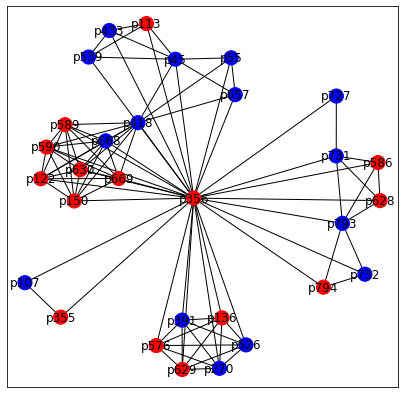

In [15]:
sub = nx.subgraph(thing.proj, thing.communities[8])
node_col = []

for node in sub.nodes():
    a = nx.get_node_attributes(G, 'Criminal_Status')[node]
    if a == 'Criminal':
        node_col.append('red')
    else:
        node_col.append('blue')

plt.rcParams.update({'figure.figsize': (7, 7)})
pos = nx.spring_layout(sub, weight=None, k=0.5, seed=23)

nx.draw_networkx(sub, pos, node_size=200, node_color=node_col)
nx.get_node_attributes(G, 'Criminal_Status')[POI]    

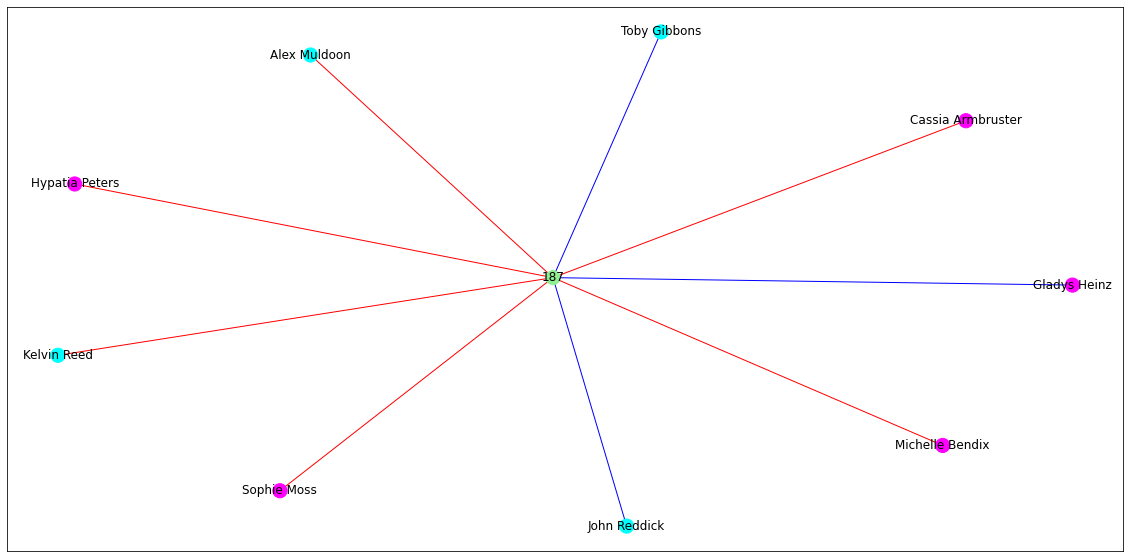

In [16]:
POI_G = nx.Graph()
POI_edges = []
nc = []
ec = []
lab = {}

for edge in G.edges():
    if POI in edge:
        POI_edges.append(edge)

for e in POI_edges:
    #print(e[1])
    POI_G.add_edges_from(G.edges(e[1]))

for node in POI_G:
    if node in p_nodes_gcc:
        if nx.get_node_attributes(G, 'sex')[node] == '1':
            nc.append('aqua')
        else:
            nc.append('magenta')
        lab[node] = (f"{nx.get_node_attributes(G, 'first')[node]} {nx.get_node_attributes(G, 'last')[node]}")
    elif node in c_nodes_gcc:
        nc.append('lightgreen')
        lab[node] = node
    else:
        nc.append('yellow') #none should ever show yellow!! something is wrong if they do
    
        
for edge in POI_G.edges():
    try:
        a = nx.get_edge_attributes(G, 'role')[edge]
    except:
        a = nx.get_edge_attributes(G, 'role')[(edge[1], edge[0])]
    if a == 'Victim':
        ec.append('blue')
    elif a == 'Suspect':
        ec.append('red')
    elif a == 'Witness':
        ec.append('green')
    else:
        ec.append('black')




        
plt.rcParams.update({'figure.figsize': (20, 10)})
pos = nx.spring_layout(POI_G, seed=13)

nx.draw_networkx(POI_G, pos, node_size=200, node_color=nc, edge_color=ec, labels=lab)

In [ ]:
for c in range(len(communities)):
    com_bet = []
    for per in communities[c]:
        com_bet.append(bet_centrality[per])
    
    print(c, max(com_bet))

## Now same again, but using crimes as projection.

In [ ]:
# project onto crimes and visualise
C = bipartite.weighted_projected_graph(G0, c_nodes_gcc)

print('C',len(C.nodes()), len(C.edges()))

plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(C, seed=23)

nx.draw_networkx(C, pos, node_size=60, with_labels=False)

In [ ]:
communities_c = sorted(comms.greedy_modularity_communities(C), key=len, reverse=True) #14 coms modularity 0.813
#communities_c = sorted(comms.label_propagation_communities(C), key=len, reverse=True) #50 coms modularity 0.763

# Count the communities
print(f"There are {len(communities_c)} communities.")

comms.modularity(C, communities_c)

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(0,10): 
    com = C.subgraph(communities_c[i])
    print(i, len(com.nodes))
    plt.subplot(2,5,i+1)
    nx.draw_spring(com, node_size=40) #, with_labels=True
#plt.savefig(f'../Figures/1-10_C_community.jpg')

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(10,14): 
    com = C.subgraph(communities_c[i])
    print(i, len(com.nodes))
    plt.subplot(2,5,i-9)
    nx.draw_spring(com, node_size=40) #, with_labels=True
#plt.savefig(f'../Figures/11-14_C_community.jpg')

In [ ]:
COI = '415'
for i in range(len(communities_c)):
    if COI in communities_c[i]:
        print(i)
        highlight = i

highlight = 12 #choose a community to highlight via it's index in the communities list

node_col = []

for node in C.nodes():
    if node in communities_c[highlight]:
        node_col.append('red')
    else:
        node_col.append('blue')


plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(C, seed=23)

nx.draw_networkx(C, pos, node_size=60, node_color=node_col, with_labels=False)

#plt.savefig(f'../Figures/community_{highlight}_crime_projection.jpg')

In [ ]:
node_col = []

for node in G0.nodes():
    if node in communities_c[highlight]:
        node_col.append('red')
    elif node in p_nodes_gcc:
        node_col.append('blue')
    else:
        node_col.append('green')


plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(G0, seed=23)

nx.draw_networkx(G0, pos, node_size=60, node_color=node_col, with_labels=False)

#plt.savefig(f'../Figures/c_community_{highlight}_lcc_no projection.jpg')

In [ ]:
lab = {}
no = []
ec = []
nc = []

for cri in communities_c[highlight]:
    no.append(cri)
    lab[cri] = f'{cri}'
    for edge in G0.edges(cri):
        no.append(edge[1])
    
no = set(no)       
for node in no:
    if node in c_nodes_gcc:
        nc.append('green')
        
    elif nx.get_node_attributes(G, 'sex')[node] == '1':
        nc.append('aqua')
        lab[node] = f"{nx.get_node_attributes(G, 'first')[node]} {nx.get_node_attributes(G, 'last')[node]}"
    else:
        nc.append('magenta')
        lab[node] = f"{nx.get_node_attributes(G, 'first')[node]} {nx.get_node_attributes(G, 'last')[node]}"

In [ ]:
hi = G0.subgraph(no)
ec = []

for c in hi.edges():
    a = nx.get_edge_attributes(hi, 'role')[c]
    if a == 'Victim':
        ec.append('blue')
    elif a == 'Suspect':
        ec.append('red')
    elif a == 'Witness':
        ec.append('green')
    else:
        ec.append('black')

plt.rcParams.update({'figure.figsize': (15, 15)})
pos = nx.spring_layout(hi, seed=23)

nx.draw_networkx(hi, pos, node_size=200, edge_color=ec, node_color = nc, labels=lab)

#plt.savefig(f'../Figures/c_community_{highlight}_focus_labelled.jpg')

## Look at suspects only:

In [ ]:
sus_edge = []
sus_nodes = []
for edge in G.edges():
    if nx.get_edge_attributes(G, 'role')[edge] == 'Suspect':
        sus_edge.append(edge)
        sus_nodes.append(edge[0])
       

len(set(sus_nodes)),len(sus_edge)

In [ ]:
#S = G.subgraph(sus_nodes)
S = nx.Graph()

for n in sus_nodes:
    S.add_node(n, bipartite=0, data=True)
    
for e in sus_edge:
    #print(e)
    S.add_node(e[1], bipartite=1, data=True)

S.add_edges_from(sus_edge)
#print(sus_edge)
print(len(S.nodes()))
Scc = sorted(nx.connected_components(S), key=len, reverse=True)
# selecting the biggest component
print(len(Scc[0])) #p815 in Scc[2]
S0 = S.subgraph(Scc[0])
print('Scc length', len(Scc))

p_nodes_scc = {n for n, d in S0.nodes(data=True) if d["bipartite"] == 0}
c_nodes_scc = set(S0) - p_nodes_scc

print(len(p_nodes_scc), len(c_nodes_scc))

plt.rcParams.update({'figure.figsize': (15, 10)})
pos = nx.spring_layout(S, seed=23)

nx.draw_networkx(S, pos, node_size=60, with_labels=False)

In [ ]:
# project onto people and visualise
Sp = bipartite.weighted_projected_graph(S0, p_nodes_scc)

print('Sp',len(Sp.nodes()), len(Sp.edges()))

#Suspects only largest connected component
plt.rcParams.update({'figure.figsize': (15, 10)})
pos = nx.spring_layout(Sp, seed=23)

nx.draw_networkx(Sp, pos, node_size=60, with_labels=False)

In [ ]:
communities_sp = sorted(comms.greedy_modularity_communities(Sp), key=len, reverse=True) #17 coms modularity 0.770
#communities_sp = sorted(comms.label_propagation_communities(Sp), key=len, reverse=True) #54 coms modularity 0.745

# Count the communities
print(f"There are {len(communities_sp)} communities.")


for i in range(len(communities_sp)):
    if POI in communities_sp[i]:
        print(f'The POI ({POI}) is in community {i}')
        highlight = i #sets the POI's community to be highlighted in graphs below

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(0,len(communities_sp)): 
    com = Sp.subgraph(communities_sp[i])
    print(i, len(com.nodes))
    plt.subplot(2,5,i+1)
    nx.draw_spring(com, node_size=40) #, with_labels=True
#plt.savefig(f'../Figures/1-10_Sp_community.jpg')

In [ ]:
highlight = 1 #choose a community to highlight via it's index in the communities list

node_col = []

for node in Sp.nodes():
    if node in communities_sp[0]:
        node_col.append('red')
    elif node in communities_sp[1]:
        node_col.append('green')
    elif node in communities_sp[2]:
        node_col.append('purple')
    elif node in communities_sp[3]:
        node_col.append('aqua')
    else:
        node_col.append('blue')


plt.rcParams.update({'figure.figsize': (15, 10)})
pos = nx.spring_layout(Sp, seed=23)

nx.draw_networkx(Sp, pos, node_size=60, node_color=node_col, with_labels=False)

#plt.savefig(f'../Figures/community_{highlight}_people_projection.jpg')

In [ ]:
node_col = []

for node in G0.nodes():
    if node in communities_sp[highlight]:
        node_col.append('red')
    elif node in c_nodes_gcc:
        node_col.append('green')
    else:
        node_col.append('blue')


plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(G0, seed=23)

nx.draw_networkx(G0, pos, node_size=60, node_color=node_col, with_labels=False)

#plt.savefig(f'../Figures/community_{highlight}_lcc_no projection.jpg')

In [ ]:
ed = []
lab = {}

for per in communities_sp[highlight]:
    print('\n------\n\n',nx.get_node_attributes(G, 'first')[per], nx.get_node_attributes(G, 'last')[per], nx.get_node_attributes(G, 'sex')[per])
    lab[per] = (f"{nx.get_node_attributes(G, 'first')[per]} {nx.get_node_attributes(G, 'last')[per]}", per)
    for c in G.edges([per]):
        if nx.get_edge_attributes(G0, 'role')[c] == 'Suspect':
            print(c, nx.get_edge_attributes(G0, 'role')[c])
            ed.append(c[1])
            lab[c[1]] = f'{c[1]}'
        
for i in communities_sp[highlight]:
    ed.append(i)

In [ ]:
nc = []
ec = []

hi = G.subgraph(ed)

for node in hi:
    if node in communities_sp[highlight]:
        if nx.get_node_attributes(G, 'sex')[node] == '1':
            nc.append('blue')
        else:
            nc.append('magenta')
    elif node in c_nodes_gcc:
        nc.append('green')
    else:
        nc.append('yellow') #none should ever show yellow!! something is wrong if they do
        
for edge in hi.edges():
    a = nx.get_edge_attributes(hi, 'role')[edge]
    if a == 'Victim':
        ec.append('white')
    elif a == 'Suspect':
        ec.append('red')
    elif a == 'Witness':
        ec.append('white')
    else:
        ec.append('white')
        
        

plt.rcParams.update({'figure.figsize': (10, 10)})
pos = nx.spring_layout(hi, seed=23)

nx.draw_networkx(hi, pos, node_size=200, node_color=nc, edge_color=ec, labels=lab)

#plt.savefig(f'../Figures/community_{highlight}_focus_labelled.jpg')

In [ ]:
for c in communities_sp:
    peeps = []
    for p in c:
        peeps.append(nx.get_node_attributes(G, 'last')[p])
    print(len(c), len(peeps), len(set(peeps)))


In [ ]:
F = nx.Graph()
F.add_edges_from([['p1','c1'], ['p1','c2'], ['p2','c1'], ['p2','c2'], ['p3','c2']])
top = ['p1', 'p2', 'p3']
F.edges()
nx.is_bipartite(F)
F_p = bipartite.weighted_projected_graph(F, top)

nx.get_edge_attributes(F_p, 'weight')

In [ ]:
x = comms.k_clique_communities(F_p, 2)

for i in x:
    print(i)

62


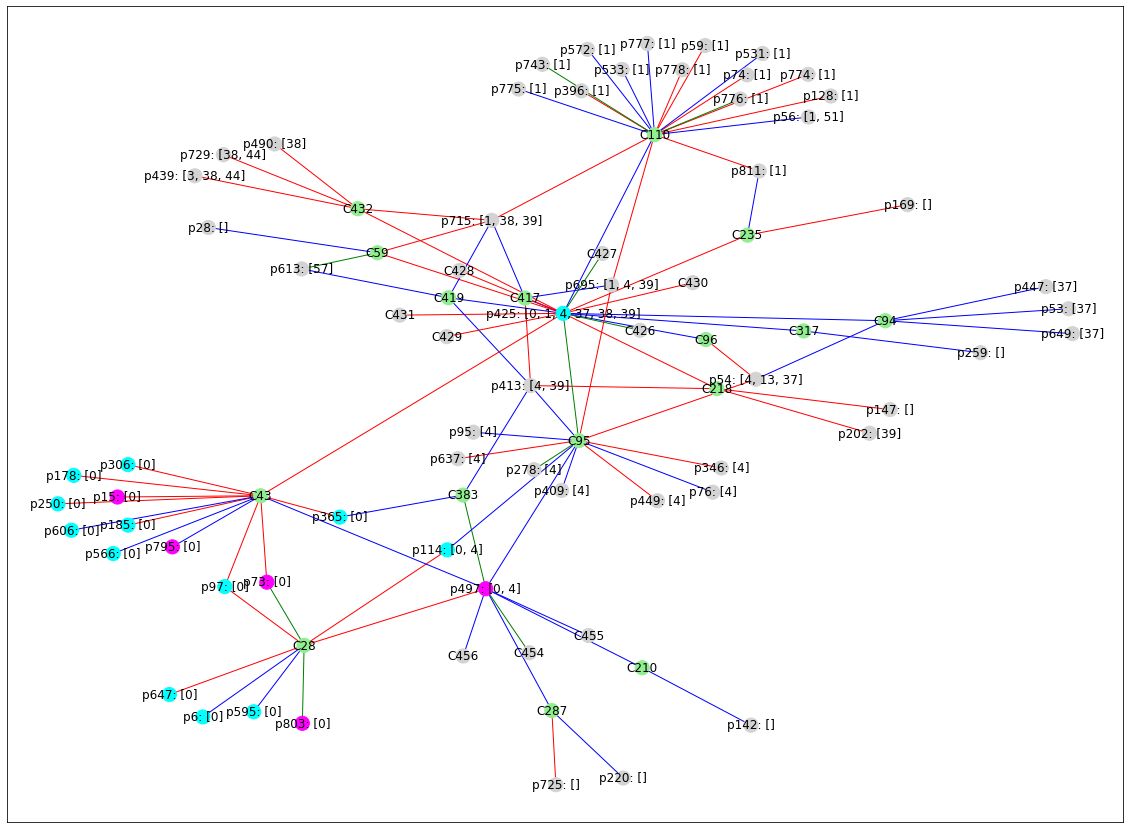

In [147]:
B = nx.read_edgelist(data)
graph = np.loadtxt(DATA, dtype=str)
a = np.unique(graph[:,0]) # people nodes
b = np.unique(graph[:,1]) # crime nodes
a = ['p' + a for a in a] # add string to differentiate

G = nx.Graph()

# add nodes
for j in range(len(a)):
    G.add_node(a[j], bipartite=0, data=True, first=firsts[j], last=lasts[j], sex=sex[j], Community = []) #Add attributes name and sex

G.add_nodes_from(b, bipartite=1, data=True)

# add edges
i = 0
for edge in B.edges():
    G.add_edge(edge[0], edge[1], role=role[i])
    i+=1



    

cliques = list(nx.find_cliques(P))
co = 0 #choose community to display here
c = list(comms.k_clique_communities(P,5, cliques = cliques))
x = sorted(list(c), key=len, reverse= True)
print(len(x))

POI_edges = []
nc = []
ec = []
lab = {}
x_ = list(x[co]) 

for node in x_:
    for e in G.edges(node):
        POI_edges.append(e[1])
        for e in G.edges(e[1]):
            POI_edges.append(e[1])
    POI_edges.append(node)
    
    

#print(POI_edges)
    
POI_G = nx.subgraph(G, POI_edges)

a = 0
for community in x:
    #print(a, community)
    for c in community:
        G.nodes[c]['Community'].append(a)
    a+=1



for node in POI_G.nodes():
    #print(node)
    if node in p_nodes_gcc:
        if co in nx.get_node_attributes(G, 'Community')[node]:
            if nx.get_node_attributes(G, 'sex')[node] == '1':
                nc.append('aqua')
            else:
                nc.append('magenta')
        else:
            nc.append('lightgrey')
        lab[node] = (f"{node}: {nx.get_node_attributes(G, 'Community')[node]}")
    elif node in c_nodes_gcc:
        if POI_G.degree(node)>1:
            nc.append('lightgreen')
        else:    
            nc.append('lightgrey')
        lab[node] = f'C{node}'
    else:
        nc.append('yellow')
    
        
for edge in POI_G.edges():
    try:
        a = nx.get_edge_attributes(G, 'role')[edge]
    except:
        a = nx.get_edge_attributes(G, 'role')[(edge[1], edge[0])]
    if a == 'Victim':
        ec.append('blue')
    elif a == 'Suspect':
        ec.append('red')
    elif a == 'Witness':
        ec.append('green')
    else:
        ec.append('black')




        
plt.rcParams.update({'figure.figsize': (20, 15)})
pos = nx.spring_layout(POI_G, seed=13, k=0.1)

nx.draw_networkx(POI_G, pos, node_size=200,node_color=nc,  edge_color=ec, labels=lab)

In [148]:
for i in range(len(x)):
    print(f'Community {i}, length {len(list(x[i]))} nodes:\n')
    POI_G = nx.subgraph(P, list(x[i]))

    for node in sorted(POI_G.nodes()):
        print(node)
        for edge in G.edges([node]):
            print(edge[1], end = ', ')
        print('\n')

Community 0, length 18 nodes:

p114
28, 95, 

p15
43, 

p178
43, 

p185
43, 

p250
43, 

p306
43, 

p365
43, 383, 

p425
43, 59, 94, 95, 96, 110, 218, 235, 317, 417, 419, 426, 427, 428, 429, 430, 431, 432, 

p497
28, 43, 95, 210, 287, 383, 454, 455, 456, 

p566
43, 

p595
28, 

p6
28, 

p606
43, 

p647
28, 

p73
28, 43, 

p795
43, 

p803
28, 

p97
28, 43, 

Community 1, length 18 nodes:

p128
110, 193, 194, 195, 196, 197, 

p396
93, 110, 188, 401, 402, 

p425
43, 59, 94, 95, 96, 110, 218, 235, 317, 417, 419, 426, 427, 428, 429, 430, 431, 432, 

p531
110, 194, 195, 196, 197, 401, 402, 474, 475, 476, 

p533
110, 196, 198, 360, 461, 479, 

p56
34, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 

p572
110, 360, 460, 461, 479, 491, 492, 

p59
110, 

p695
95, 110, 140, 260, 376, 417, 418, 424, 521, 522, 523, 

p715
59, 85, 110, 118, 140, 417, 419, 432, 490, 531, 532, 533, 

p74
90, 91, 110, 122, 123, 124, 125, 

p743
110, 

p774
110, 460, 

p775
110, 539, 

p776
58, 110, 

p7


p534
480, 

p563
14, 480, 

p564
480, 

p613
59, 419, 480, 

p666
280, 480, 

Community 58, length 5 nodes:

p356
14, 23, 79, 80, 162, 187, 206, 377, 378, 379, 380, 

p418
79, 187, 

p45
79, 80, 

p55
79, 

p657
79, 

Community 59, length 5 nodes:

p402
405, 

p404
51, 55, 73, 169, 189, 405, 406, 407, 408, 409, 

p437
405, 406, 

p476
405, 410, 

p704
405, 

Community 60, length 5 nodes:

p190
126, 246, 247, 248, 249, 250, 

p294
248, 257, 

p329
248, 

p790
248, 

p791
248, 

Community 61, length 5 nodes:

p21
52, 53, 

p347
52, 

p549
31, 52, 60, 121, 436, 486, 487, 

p697
52, 

p779
52, 439, 



In [155]:
a= 0

for n in G.nodes():
    if 'p' in n:
        if len(nx.get_node_attributes(G, 'Community')[n]) == 0:
            a+=1
        elif len(nx.get_node_attributes(G, 'Community')[n]) > 1:
            print(n, len(nx.get_node_attributes(G, 'Community')[n]))
print(a)

p10 3
p114 2
p17 2
p2 5
p219 2
p291 2
p294 2
p304 2
p343 2
p356 7
p361 2
p37 2
p397 2
p404 3
p413 2
p418 2
p425 6
p439 3
p45 2
p497 2
p536 2
p54 3
p549 2
p56 2
p563 2
p57 2
p62 2
p695 3
p715 3
p719 2
p729 2
p763 2
p812 2
451
